#### Library

In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import math
import numpy as np
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, EarlyStoppingCallback
import torch

#### Load dataset

In [2]:
from datasets import load_dataset

ds = load_dataset("harouzie/vi_en-translation")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

data/train-00000-of-00001-8fc21cb8e80d3a(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/test-00000-of-00001-858c0e989d9c563(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

data/valid-00000-of-00001-99e7e50144d1c1(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

In [3]:
print(ds.keys())
print(ds)

dict_keys(['train', 'test', 'valid'])
DatasetDict({
    train: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 203272
    })
    test: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 25409
    })
    valid: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 25409
    })
})


In [4]:
# def convert_data(example):
#     return {
#         "English": example["translation"]["en"],
#         "Vietnamese": example["translation"]["vi"],
#     }
# ds = ds.map(convert_data)

In [5]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 203272
    })
    test: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 25409
    })
    valid: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 25409
    })
})


In [6]:
# from datasets import DatasetDict

# train_valid = ds  # dataset bạn đang có

# train_test = train_valid["train"].train_test_split(
#     test_size=0.1,
#     seed=42
# )

# train = train_test["train"]          # 90% của train gốc
# test  = train_test["test"]           # 10% của train gốc
# valid = train_valid["validation"]    # giữ nguyên validation

# new_ds = DatasetDict({
#     "train": train,
#     "validation": valid,
#     "test": test
# })

# new_ds


In [7]:
# new_ds = DatasetDict({
#     "train": new_ds["train"].remove_columns(["translation"]),
#     "validation": new_ds["validation"].remove_columns(["translation"]),
#     "test": new_ds["test"].remove_columns(["translation"]),
# })
# new_ds

In [8]:
train_df = pd.DataFrame(ds['train'])
val_df = pd.DataFrame(ds['valid'])
test_df = pd.DataFrame(ds['test'])

print("Train DataFrame head:")
display(train_df.head())

Train DataFrame head:


,English,Vietnamese
0,I heard that since Tom isn't feeling well he w...,tôi nghe nói rằng vì tom không khỏe nên hôm na...
1,The pharmacy is on Fresno Street,hiệu thuốc nằm trên đường fresno
2,I'm not living with him anymore.,Tôi không còn sống với anh ấy nữa.
3,I'll see what else we need to bring,tôi sẽ xem những gì chúng ta cần mang theo
4,Tom ran a hundred meters in twelve seconds.,tom chạy một trăm mét trong mười hai giây.


#### EDA Original Data

##### Overview for 3 `train`, `valid`, and `test`

In [9]:
def eda_basic(df, split_name):
    print(f"\n===== {split_name.upper()} SET =====")

    # Thông tin tổng quan
    print("\nDataFrame Info:")
    print(df.info())

    # Kiểm tra giá trị thiếu
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Kiểm tra dòng trùng lặp
    print("\nTotal duplicate rows:")
    print(df.duplicated().sum())

    # In vài dòng đầu tiên để xem cấu trúc
    print("\nSample data:")
    display(df.head())

In [10]:
eda_basic(train_df, "train_df")
eda_basic(val_df, "validation")
eda_basic(test_df, "test")


===== TRAIN_DF SET =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203272 entries, 0 to 203271
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   English     203272 non-null  object
 1   Vietnamese  203272 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB
None

Missing values per column:
English       0
Vietnamese    0
dtype: int64

Total duplicate rows:
7

Sample data:


,English,Vietnamese
0,I heard that since Tom isn't feeling well he w...,tôi nghe nói rằng vì tom không khỏe nên hôm na...
1,The pharmacy is on Fresno Street,hiệu thuốc nằm trên đường fresno
2,I'm not living with him anymore.,Tôi không còn sống với anh ấy nữa.
3,I'll see what else we need to bring,tôi sẽ xem những gì chúng ta cần mang theo
4,Tom ran a hundred meters in twelve seconds.,tom chạy một trăm mét trong mười hai giây.



===== VALIDATION SET =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25409 entries, 0 to 25408
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   English     25409 non-null  object
 1   Vietnamese  25409 non-null  object
dtypes: object(2)
memory usage: 397.1+ KB
None

Missing values per column:
English       0
Vietnamese    0
dtype: int64

Total duplicate rows:
1

Sample data:


,English,Vietnamese
0,Tom and Mary bumped against each other,tom và mary va vào nhau
1,Why didn't you listen to his advice?,Tại sao bạn không nghe lời khuyên của anh ấy?
2,Do you want to see where Tom is buried?,Bạn có muốn xem nơi chôn cất tom?
3,Men are better at this than women.,đàn ông giỏi việc này hơn phụ nữ.
4,The frame itself is worth more than the picture.,khung hình có giá trị hơn hình ảnh.



===== TEST SET =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25409 entries, 0 to 25408
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   English     25409 non-null  object
 1   Vietnamese  25409 non-null  object
dtypes: object(2)
memory usage: 397.1+ KB
None

Missing values per column:
English       0
Vietnamese    0
dtype: int64

Total duplicate rows:
0

Sample data:


,English,Vietnamese
0,They refused to be drafted.,họ đã từ chối để được soạn thảo.
1,Tom won't be here tomorrow. I guarantee you th...,Tom sẽ không ở đây vào ngày mai. tôi đảm bảo v...
2,"In times like this, we should all pull together.","trong những lúc như thế này, tất cả chúng ta n..."
3,He will object to your going abroad.,anh ấy sẽ phản đối việc bạn ra nước ngoài
4,We'll be back as soon as possible.,chúng tôi sẽ quay lại sớm nhất có thể


##### Detail for `train` dataset

Phân bố độ dài câu

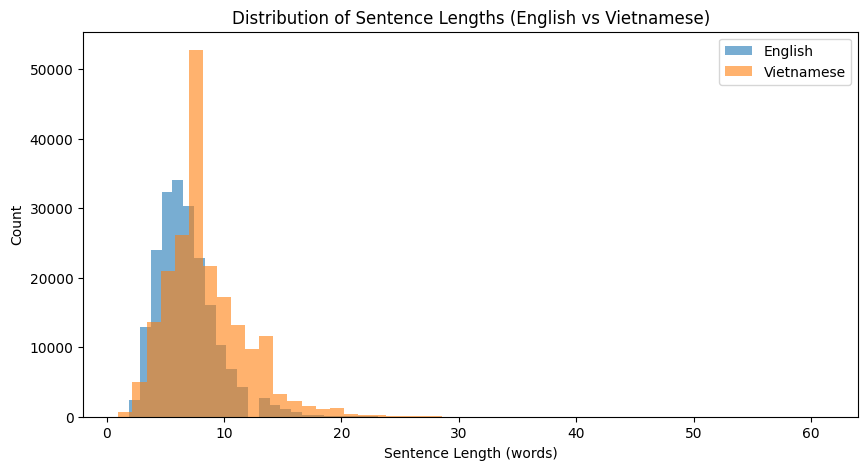

In [11]:
train_df['en_len'] = train_df['English'].apply(lambda x: len(x.split()))
train_df['vi_len'] = train_df['Vietnamese'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.hist(train_df['en_len'], bins=50, alpha=0.6, label='English')
plt.hist(train_df['vi_len'], bins=50, alpha=0.6, label='Vietnamese')
plt.xlabel("Sentence Length (words)")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Sentence Lengths (English vs Vietnamese)")
plt.show()

Tỷ lệ độ dài En/Vi (độ khớp giữa 2 ngôn ngữ)

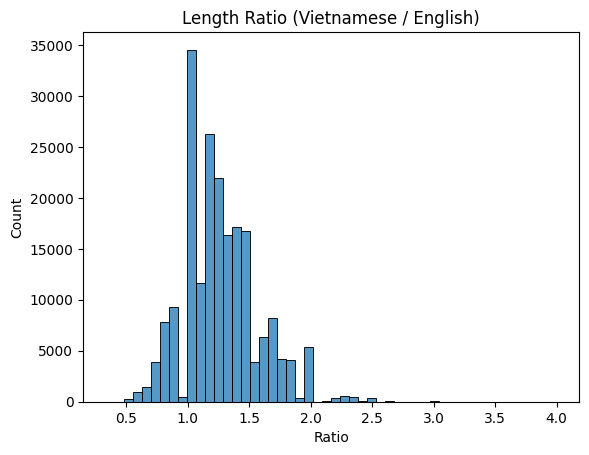

In [12]:
train_df['len_ratio'] = train_df['vi_len'] / train_df['en_len']
sns.histplot(train_df['len_ratio'], bins=50)
plt.title("Length Ratio (Vietnamese / English)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.show()

In [13]:
# Cặp có độ lệch lớn
outliers = train_df[(train_df['len_ratio'] == 3.0)]

# In tổng số cặp bị lệch
# print(f"Tổng số cặp bị lệch độ dài: {len(outliers)}")

# Hiển thị vài ví dụ đầu
from IPython.display import display
display(outliers[['English', 'Vietnamese', 'en_len', 'vi_len', 'len_ratio']].head(10))


,English,Vietnamese,en_len,vi_len,len_ratio
2531,Nothing'll happen.,sẽ không có gì xảy ra,2,6,3.0
5514,Something happened recently.,một cái gì đó đã xảy ra gần đây.,3,9,3.0
6706,Everything's ruined.,mọi thứ đều bị hủy hoại,2,6,3.0
10193,We'll rebuild,chúng tôi sẽ xây dựng lại,2,6,3.0
10433,We're exercising.,chúng tôi đang tập thể dục,2,6,3.0
11530,We're energetic.,chúng tôi tràn đầy năng lượng.,2,6,3.0
12220,He's antisocial,anh ấy chống đối xã hội,2,6,3.0
14201,Something's happening here,một cái gì đó đang xảy ra ở đây,3,9,3.0
22203,That's absolutely unacceptable,điều đó hoàn toàn không thể chấp nhận được,3,9,3.0
23133,You're unscrupulous,bạn là người vô đạo đức,2,6,3.0


Thống kê mô tả độ dài (mean, median, std)

Mục đích của thống kê này là để chọn tham số max_length hợp lý khi tokenize. Khi huấn luyện mô hình dịch (như ViT5, mT5, MarianMT) cần phải đặt tham số max_length.
 * Nếu max_length quá thấp → cắt mất nội dung câu.
 * Nếu quá cao → lãng phí bộ nhớ, tốc độ train chậm.

In [14]:
print("English length stats:")
print(train_df['en_len'].describe())

print("\nVietnamese length stats:")
print(train_df['vi_len'].describe())

English length stats:
count    203272.000000
mean          6.770500
std           2.702614
min           1.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          47.000000
Name: en_len, dtype: float64

Vietnamese length stats:
count    203272.000000
mean          8.347244
std           3.443757
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          61.000000
Name: vi_len, dtype: float64


Từ phổ biến nhất (Word Frequency)

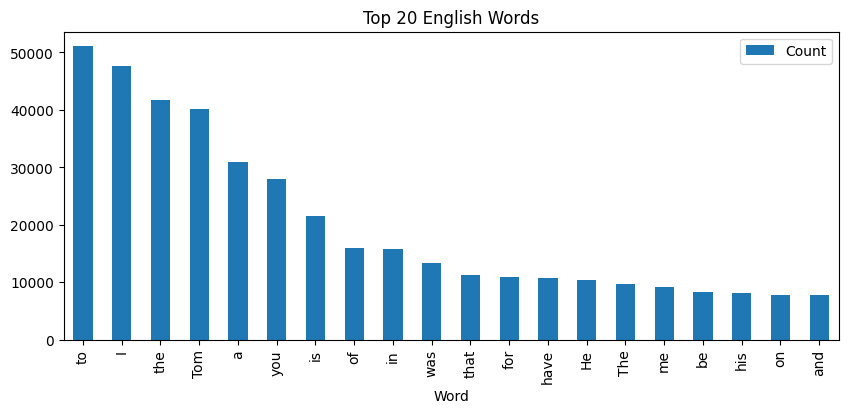

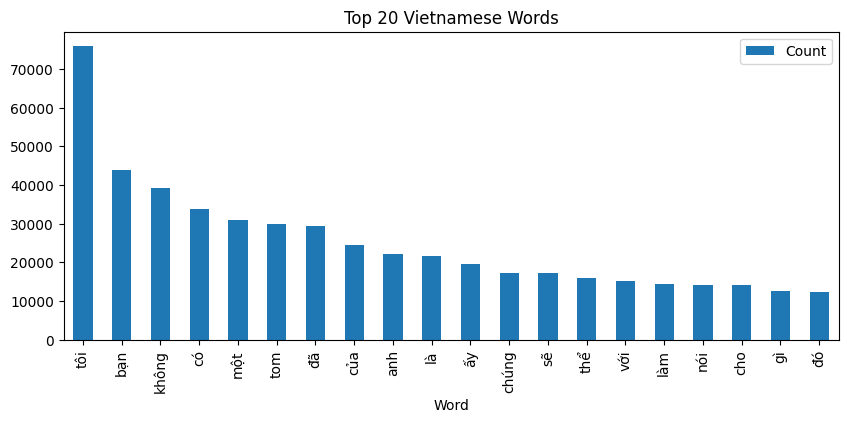

In [15]:
en_words = ' '.join(train_df['English']).split()
vi_words = ' '.join(train_df['Vietnamese']).split()

en_common = Counter(en_words).most_common(20)
vi_common = Counter(vi_words).most_common(20)

pd.DataFrame(en_common, columns=['Word', 'Count']).plot.bar(x='Word', y='Count', title='Top 20 English Words', figsize=(10,4))
pd.DataFrame(vi_common, columns=['Word', 'Count']).plot.bar(x='Word', y='Count', title='Top 20 Vietnamese Words', figsize=(10,4))
plt.show()


Heatmap tương quan độ dài En–Vi

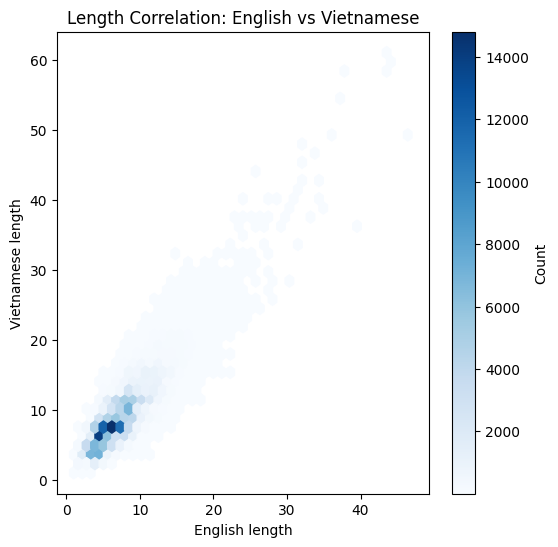

In [16]:
plt.figure(figsize=(6,6))
plt.hexbin(train_df['en_len'], train_df['vi_len'], gridsize=40, cmap='Blues', mincnt=1)
plt.xlabel('English length')
plt.ylabel('Vietnamese length')
plt.title('Length Correlation: English vs Vietnamese')
plt.colorbar(label='Count')
plt.show()

Phân bố chính tập trung gần đường chéo (y ≈ x). Điều này cho thấy độ dài câu giữa hai ngôn ngữ có mối tương quan tuyến tính mạnh. Khi câu tiếng Anh dài hơn, câu tiếng Việt cũng dài hơn tương ứng.

Phần lớn dữ liệu tập trung tại vùng 5–15 (English) và 7–20 (Vietnamese). Có thể thấy đa phần các câu trong dữ liệu ngắn hoặc trung bình.

Không có dấu hiệu lệch hoặc nhiễu.

In [17]:
corr = train_df['en_len'].corr(train_df['vi_len'])
print(f"Hệ số tương quan Pearson giữa độ dài câu: {corr:.3f}")

Hệ số tương quan Pearson giữa độ dài câu: 0.833


Hệ số tương quan giữa độ dài câu tiếng Anh và tiếng Việt đạt r ≈ 0.833, cho thấy hai ngôn ngữ có mức độ tương ứng cao về mặt cấu trúc.

In [18]:
display(train_df.head())

,English,Vietnamese,en_len,vi_len,len_ratio
0,I heard that since Tom isn't feeling well he w...,tôi nghe nói rằng vì tom không khỏe nên hôm na...,14,17,1.214286
1,The pharmacy is on Fresno Street,hiệu thuốc nằm trên đường fresno,6,6,1.000000
2,I'm not living with him anymore.,Tôi không còn sống với anh ấy nữa.,6,8,1.333333
3,I'll see what else we need to bring,tôi sẽ xem những gì chúng ta cần mang theo,8,10,1.250000
4,Tom ran a hundred meters in twelve seconds.,tom chạy một trăm mét trong mười hai giây.,8,9,1.125000


#### Synthetic data

In [19]:
df_synth = pd.read_json('/content/SyntheticDataChatGPT.json')
print(df_synth.head())

                                             english  \
0  I usually wake up early to prepare breakfast f...   
1  She didn’t realize she had left her keys insid...   
2  If it rains tomorrow, we will have to cancel t...   
3  The documents were submitted late because the ...   
4  He asked me whether I could help him finish th...   

                                          vietnamese  
0  Tôi thường dậy sớm để chuẩn bị bữa sáng cho gi...  
1  Cô ấy không nhận ra mình đã để quên chìa khóa ...  
2  Nếu ngày mai trời mưa, chúng tôi sẽ phải hủy b...  
3   Tài liệu bị nộp trễ vì hệ thống đột ngột bị sập.  
4  Anh ấy hỏi tôi liệu tôi có thể giúp anh hoàn t...  


In [20]:
print(len(df_synth))

5067


In [21]:
print("Total null rows")
print(df_synth.isnull().sum())

Total null rows
english       0
vietnamese    0
dtype: int64


Phân bố độ dài câu

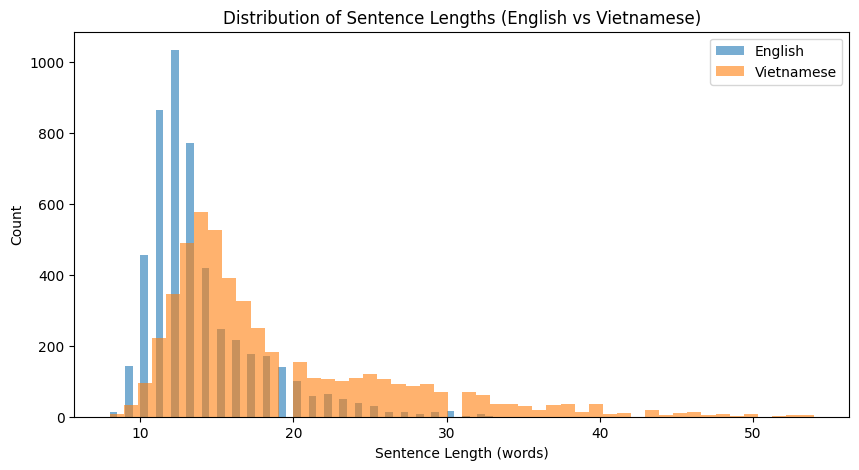

In [22]:
df_synth["en_len"] = df_synth["english"].str.split().str.len()
df_synth["vi_len"] = df_synth["vietnamese"].str.split().str.len()

plt.figure(figsize=(10,5))
plt.hist(df_synth['en_len'], bins=50, alpha=0.6, label='English')
plt.hist(df_synth['vi_len'], bins=50, alpha=0.6, label='Vietnamese')
plt.xlabel("Sentence Length (words)")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Sentence Lengths (English vs Vietnamese)")
plt.show()

Biểu đồ phân phối độ dài câu cho thấy câu tiếng Anh chủ yếu rơi vào khoảng 10–18 từ và có phân phối khá tập trung, giúp mô hình encoder xử lý dễ dàng. Ngược lại, câu tiếng Việt có phân phối rộng hơn (13–40+ từ), phản ánh đặc trưng ngôn ngữ và tính diễn giải dài hơn. Hiện tượng này phù hợp với đặc thù dịch EN→VI.

In [23]:
print(df_synth[["en_len","vi_len"]].describe())

            en_len       vi_len
count  5067.000000  5067.000000
mean     13.673771    18.871719
std       3.752450     7.710522
min       8.000000     8.000000
25%      11.000000    14.000000
50%      13.000000    16.000000
75%      15.000000    22.000000
max      33.000000    54.000000


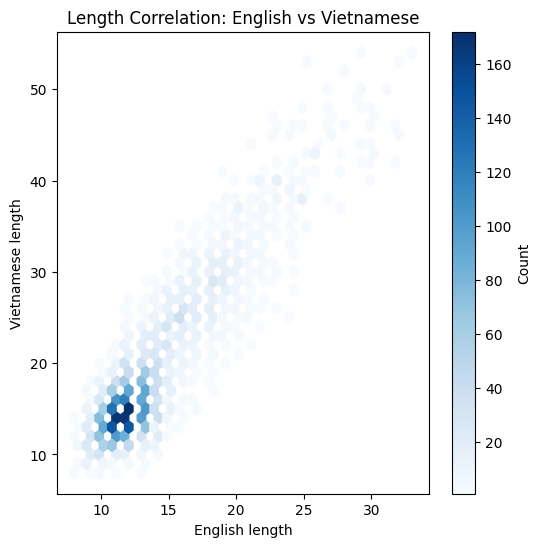

In [24]:
plt.figure(figsize=(6,6))
plt.hexbin(df_synth['en_len'], df_synth['vi_len'], gridsize=40, cmap='Blues', mincnt=1)
plt.xlabel('English length')
plt.ylabel('Vietnamese length')
plt.title('Length Correlation: English vs Vietnamese')
plt.colorbar(label='Count')
plt.show()

In [25]:
corr = df_synth['en_len'].corr(df_synth['vi_len'])
print(f"Hệ số tương quan Pearson giữa độ dài câu: {corr:.3f}")

Hệ số tương quan Pearson giữa độ dài câu: 0.903


In [26]:
df_synth = df_synth.rename(columns={
    "english": "English",
    "vietnamese": "Vietnamese"
})

Combine data

In [27]:
train_df = pd.concat([train_df, df_synth], ignore_index=True)

In [28]:
print("Tổng số dòng trước khi gộp:", len(train_df))
train_df = pd.concat([train_df, df_synth], ignore_index=True)
print("Tổng số dòng sau khi gộp:", len(train_df))
print(train_df.tail())

Tổng số dòng trước khi gộp: 208339
Tổng số dòng sau khi gộp: 213406
                                                  English  \
213401  The security team identified multiple unauthor...   
213402  He wondered whether the glowing stones were re...   
213403  The government expanded renewable energy proje...   
213404  She could not decode the encrypted tablet beca...   
213405  The cultivator intensified his focus as he pre...   

                                               Vietnamese  en_len  vi_len  \
213401  Nhóm an ninh xác định nhiều lần đăng nhập trái...      12      15   
213402  Anh tự hỏi liệu những viên đá phát sáng đang p...      15      24   
213403  Chính phủ mở rộng các dự án năng lượng tái tạo...      13      23   
213404  Cô không thể giải mã ngọc giản được mã hóa vì ...      14      21   
213405  Người tu luyện tăng cường tập trung khi chuẩn ...      14      18   

        len_ratio  
213401        NaN  
213402        NaN  
213403        NaN  
213404        NaN  
21

#### Data Preproccessing

In [29]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=2fe3611b8d3c005a351527537bb63d9a677e3ee399519c3df7a902316a7f0679
  Stored in directory: /root/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
Successfully built langid


In [30]:
from datasets import load_dataset, concatenate_datasets
import html, re, unicodedata
from bs4 import BeautifulSoup
import langid
import regex

In [31]:
# =======================
# CLEAN TEXT FUNCTION
# =======================
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # 0) Trim và bảo đảm là str
    text = str(text).strip()

    # 1) Remove HTML + decode entities
    text = BeautifulSoup(text, "html.parser").get_text()
    text = html.unescape(text)

    # 2) Unicode normalize
    text = unicodedata.normalize("NFC", text)

    # 3) Remove URLs, emails, tags
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"[@#]\w+", "", text)

    # 4) Convert repeated dash sequences to em-dash with spaces around (but keep single hyphen)
    text = re.sub(r"[\u2012\u2013\u2014\u2015\-]{2,}", " — ", text)

    # 5) Remove uncommon symbols
    text = re.sub(r"[◆●■♡→•※✦►◄▽▼▲♦★☆■□▪▫]", "", text)

    # 6) Allow only valid characters (EN + VI + punctuation)
    text = regex.sub(r"[^\p{Letter}\p{Number}\p{Punctuation}\p{Separator}]", " ", text)

    # 7) Normalize repeating chars (soooo → soo)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # 8) Final trim
    text = re.sub(r"\s+", " ", text).strip()

    return text


# ==========================
# PREPROCESS FUNCTION
# ==========================
def preprocess_text(text):
    text = clean_text(text)
    return text

print("=== ORIGINAL COUNTS ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =======================
# PREPROCESS
# =======================
print("Preprocess on train...")
train_df["en"] = train_df["English"].apply(preprocess_text)
train_df["vi"] = train_df["Vietnamese"].apply(preprocess_text)

# print("Preprocess on valid...")
val_df["en"] = val_df["English"].apply(preprocess_text)
val_df["vi"] = val_df["Vietnamese"].apply(preprocess_text)

# print("Preprocess on test...")
test_df["en"] = test_df["English"].apply(preprocess_text)
test_df["vi"] = test_df["Vietnamese"].apply(preprocess_text)

print("\n=== AFTER CLEAN ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =======================
# REMOVE EMPTY ROWS
# =======================
print("Remove empty rows on train...")
train_df = train_df[(train_df["en"].str.strip() != "") & (train_df["vi"].str.strip() != "")]

print("Remove empty rows on valid...")
val_df   = val_df[(val_df["en"].str.strip() != "") & (val_df["vi"].str.strip() != "")]

print("Remove empty rows on test...")
test_df  = test_df[(test_df["en"].str.strip() != "") & (test_df["vi"].str.strip() != "")]

print("\n=== AFTER REMOVE EMPTY ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =======================
# REMOVE DUPLICATES
# =======================
print("Remove duplicate rows on train...")
train_df = train_df.drop_duplicates(subset=["en", "vi"])

print("Remove duplicate rows on valid...")
val_df   = val_df.drop_duplicates(subset=["en", "vi"])

print("Remove duplicate rows on test...")
test_df  = test_df.drop_duplicates(subset=["en", "vi"])

print("\n=== AFTER REMOVE DUPLICATES ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =========================
# FILTER BY SENTENCE LENGTH
# =========================
print("Filter length on train...")
train_df = train_df[
    train_df["en"].str.split().str.len().between(1, 80) &
    train_df["vi"].str.split().str.len().between(1, 80)
]

print("Filter length on valid...")
val_df = val_df[
    val_df["en"].str.split().str.len().between(1, 80) &
    val_df["vi"].str.split().str.len().between(1, 80)
]

print("Filter length on test...")
test_df = test_df[
    test_df["en"].str.split().str.len().between(1, 80) &
    test_df["vi"].str.split().str.len().between(1, 80)
]

print("\n=== AFTER LENGTH FILTER ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =================
# FILTER BY LANGID
# =================
langid.set_languages(["en", "vi"])

# ---- Train ----
print("Filter language on train...")
train_lang_mask = (
    (train_df["en"].apply(lambda x: langid.classify(x)[0]) == "en") &
    (train_df["vi"].apply(lambda x: langid.classify(x)[0]) == "vi")
)

train_removed_df = train_df[~train_lang_mask]  # lưu mẫu bị loại
train_df = train_df[train_lang_mask]           # giữ lại mẫu đúng

# ---- Val ----
print("Filter language on valid...")
val_lang_mask = (
    (val_df["en"].apply(lambda x: langid.classify(x)[0]) == "en") &
    (val_df["vi"].apply(lambda x: langid.classify(x)[0]) == "vi")
)

val_removed_df = val_df[~val_lang_mask]
val_df = val_df[val_lang_mask]

# ---- Test ----
print("Filter language on test...")
test_lang_mask = (
    (test_df["en"].apply(lambda x: langid.classify(x)[0]) == "en") &
    (test_df["vi"].apply(lambda x: langid.classify(x)[0]) == "vi")
)

test_removed_df = test_df[~test_lang_mask]
test_df = test_df[test_lang_mask]

print("\n=== AFTER LANGID FILTER ===")
print(f"Train: {len(train_df)} (removed: {len(train_removed_df)})")
print(f"Valid: {len(val_df)} (removed: {len(val_removed_df)})")
print(f"Test : {len(test_df)} (removed: {len(test_removed_df)})")

=== ORIGINAL COUNTS ===
Train: 213406
Valid: 25409
Test : 25409
Preprocess on train...

=== AFTER CLEAN ===
Train: 213406
Valid: 25409
Test : 25409
Remove empty rows on train...
Remove empty rows on valid...
Remove empty rows on test...

=== AFTER REMOVE EMPTY ===
Train: 213406
Valid: 25409
Test : 25409
Remove duplicate rows on train...
Remove duplicate rows on valid...
Remove duplicate rows on test...

=== AFTER REMOVE DUPLICATES ===
Train: 208162
Valid: 25408
Test : 25409
Filter length on train...
Filter length on valid...
Filter length on test...

=== AFTER LENGTH FILTER ===
Train: 208162
Valid: 25408
Test : 25409
Filter language on train...
Filter language on valid...
Filter language on test...

=== AFTER LANGID FILTER ===
Train: 208095 (removed: 67)
Valid: 25396 (removed: 12)
Test : 25402 (removed: 7)


In [32]:
# train_df = train_df.rename(columns={
#     "vi": "input_text",
#     "en": "target_text"
# })

# val_df = val_df.rename(columns={
#     "vi": "input_text",
#     "en": "target_text"
# })

# test_df = test_df.rename(columns={
#     "vi": "input_text",
#     "en": "target_text"
# })


In [33]:
from datasets import Dataset

def df_to_hfds(df):
    ds = Dataset.from_pandas(df.reset_index(drop=True))
    if "__index_level_0__" in ds.column_names:
        ds = ds.remove_columns(["__index_level_0__"])
    return ds

ds_train = df_to_hfds(train_df)
ds_valid = df_to_hfds(val_df)
ds_test  = df_to_hfds(test_df)

In [34]:
# =======================
# PREFIX BUILDING
# =======================
def to_prefix_vi2en(example):
    """Prefix cho Việt → Anh"""
    prefix = f"vi_en: {example['vi']}"
    return {'input_text': prefix, 'target_text': example['en']}


print("Mapping to prefix on train...")
ds_vi2en_train = ds_train.map(to_prefix_vi2en, \
                              remove_columns=ds_train.column_names, \
                              num_proc=4)

print("Mapping to prefix on valid...")
ds_vi2en_valid = ds_valid.map(to_prefix_vi2en, \
                              remove_columns=ds_valid.column_names, \
                              num_proc=2)

print("Mapping to prefix on test...")
ds_vi2en_test = ds_test.map(to_prefix_vi2en, \
                            remove_columns=ds_test.column_names, \
                            num_proc=2)

Mapping to prefix on train...


Map (num_proc=4):   0%|          | 0/208095 [00:00<?, ? examples/s]

Mapping to prefix on valid...


Map (num_proc=2):   0%|          | 0/25396 [00:00<?, ? examples/s]

Mapping to prefix on test...


Map (num_proc=2):   0%|          | 0/25402 [00:00<?, ? examples/s]

In [35]:
print(f"train: {len(ds_vi2en_train)} samples, valid: {len(ds_vi2en_valid)} samples, "
      f"test: {len(ds_vi2en_test)} samples")

train: 208095 samples, valid: 25396 samples, test: 25402 samples


In [36]:
for i in range(5):
    print(ds_vi2en_train[i])
    print("------")

{'input_text': 'vi_en: tôi nghe nói rằng vì tom không khỏe nên hôm nay anh ấy sẽ không đến trường', 'target_text': "I heard that since Tom isn't feeling well he won't come to school today"}
------
{'input_text': 'vi_en: hiệu thuốc nằm trên đường fresno', 'target_text': 'The pharmacy is on Fresno Street'}
------
{'input_text': 'vi_en: Tôi không còn sống với anh ấy nữa.', 'target_text': "I'm not living with him anymore."}
------
{'input_text': 'vi_en: tôi sẽ xem những gì chúng ta cần mang theo', 'target_text': "I'll see what else we need to bring"}
------
{'input_text': 'vi_en: tom chạy một trăm mét trong mười hai giây.', 'target_text': 'Tom ran a hundred meters in twelve seconds.'}
------


In [37]:
n = len(ds_vi2en_train)
ds_train[n-5 : n]

{'English': ['The security team identified multiple unauthorized login attempts occurring during the night.',
  'He wondered whether the glowing stones were reacting to his presence or the surrounding atmosphere.',
  'The government expanded renewable energy projects to reduce long-term dependence on fossil fuels.',
  'She could not decode the encrypted tablet because several symbols were missing or damaged.',
  'The cultivator intensified his focus as he prepared to refine the unstable elemental essence.'],
 'Vietnamese': ['Nhóm an ninh xác định nhiều lần đăng nhập trái phép xảy ra trong đêm.',
  'Anh tự hỏi liệu những viên đá phát sáng đang phản ứng với sự hiện diện của anh hay với môi trường xung quanh.',
  'Chính phủ mở rộng các dự án năng lượng tái tạo để giảm sự phụ thuộc lâu dài vào nhiên liệu hóa thạch.',
  'Cô không thể giải mã ngọc giản được mã hóa vì một số ký hiệu đã bị thiếu hoặc hư hỏng.',
  'Người tu luyện tăng cường tập trung khi chuẩn bị luyện hóa nguyên tố tinh hoa bấ

#### Model

In [ ]:
ds_vi2en_train.save_to_disk("train")
ds_vi2en_valid.save_to_disk("valid")
ds_vi2en_test.save_to_disk("test")

Saving the dataset (0/1 shards):   0%|          | 0/208095 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25396 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25402 [00:00<?, ? examples/s]

In [38]:
!pip install protobuf==3.20.*
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a36bfea260202f4bf7aeebaa54b621d07dea7052372f4ed8f916b66ec2d4107b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
%%writefile mt_train_script.py

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, EarlyStoppingCallback



import evaluate
import torch
import numpy as np

# LOAD DATASET
ds_train = load_from_disk("train")
ds_valid = load_from_disk("valid")


# LOAD MODEL & TOKENIZER

MODEL_NAME = "VietAI/ViT5-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)





# TOKENIZE FUNCTION
def tokenize_fn(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        batch["target_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )["input_ids"]

    labels = [
        [(t if t != tokenizer.pad_token_id else -100) for t in label]
        for label in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs

train_tok = ds_train.map(tokenize_fn, batched=True, remove_columns=ds_train.column_names)
valid_tok = ds_valid.map(tokenize_fn, batched=True, remove_columns=ds_valid.column_names)




# METRIC (BLEU)
metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result






# TRAINING ARGUMENTS
training_args = Seq2SeqTrainingArguments(
    output_dir="./nlp_mt_endterm_vi_en_synthetic_v6_data200k",
    eval_strategy="steps",
    eval_steps=5000,

    save_strategy="steps",
    save_steps=5000,

    logging_strategy="steps",
    logging_steps=1000,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    num_train_epochs=10,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    label_smoothing_factor=0.1,
    weight_decay=0.01,


    fp16=True,
    report_to="none",
    run_name="vit5_en_vi_ft",
    group_by_length=True,
    gradient_checkpointing=True,
    predict_with_generate=True,

    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True
)





# TRAINER
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3)  # STOP nếu BLEU không cải thiện 3 lần liên tiếp
    ]
)





# TRAIN
trainer.train()
trainer.save_state()

Overwriting mt_train_script.py


In [ ]:
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [ ]:
!accelerate config default

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
!accelerate launch mt_train_script.py

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

##### draft

In [ ]:
# print(model)

In [ ]:
# print(model.config)

In [ ]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params:,}")

In [ ]:
# def tokenize_fn(batch):
#     model_inputs = tokenizer(
#         batch["input_text"],
#         max_length=64,
#         padding="max_length",
#         truncation=True,
#     )

#     labels = tokenizer(
#         batch["target_text"],
#         max_length=64,
#         padding="max_length",
#         truncation=True,
#     )["input_ids"]

#     labels = [
#         [(t if t != tokenizer.pad_token_id else -100) for t in label]
#         for label in labels
#     ]

#     model_inputs["labels"] = labels
#     return model_inputs

# train_tok = ds_train_bi.map(tokenize_fn, batched=True, remove_columns=ds_train_bi.column_names)
# valid_tok = ds_valid_bi.map(tokenize_fn, batched=True, remove_columns=ds_valid_bi.column_names)
# test_tok  = ds_test_bi.map(tokenize_fn,  batched=True, remove_columns=ds_test_bi.column_names)

In [ ]:
# metric = evaluate.load("sacrebleu")

# def postprocess_text(preds, labels):
#     preds = [pred.strip() for pred in preds]
#     labels = [[label.strip()] for label in labels]

#     return preds, labels


# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

#     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
#     result = {"bleu": result["score"]}

#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
#     result["gen_len"] = np.mean(prediction_lens)
#     result = {k: round(v, 4) for k, v in result.items()}
#     return result

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

# push_to_hub=True
# hub_model_id="tnguyen20604/nlp_mt_endterm_v4_data400k"

In [ ]:
# from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./nlp_mt_endterm_v4_data400k",
#     eval_strategy="steps",
#     eval_steps=20000,

#     save_strategy="epoch",
#     push_to_hub=True,
#     hub_model_id="tnguyen20604/nlp_mt_endterm_v4_data400k",
#     hub_strategy="every_save",
#     hub_private_repo=False,

#     logging_strategy="steps",
#     logging_steps=20000,

#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     gradient_accumulation_steps=2,

#     num_train_epochs=3,
#     learning_rate=1e-4,
#     warmup_ratio=0.05,
#     label_smoothing_factor=0.1,
#     weight_decay=0.01,


#     fp16=True,
#     report_to="none",
#     run_name="vit5_en_vi_ft",
#     group_by_length=True,
#     # gradient_checkpointing=True,
#     predict_with_generate=True,
# )


In [ ]:
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_tok,
#     eval_dataset=valid_tok,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics
# )

In [ ]:
# trainer.train()

In [ ]:
# import json
# import pandas as pd
# import matplotlib.pyplot as plt

# with open("mt_output/trainer_state.json", "r") as f:
#     state = json.load(f)

# logs = state["log_history"]

# df = pd.DataFrame(logs)

# train_df = df[df["loss"].notnull()]
# val_df = df[df["eval_loss"].notnull()]

# plt.figure(figsize=(10,5))
# plt.plot(train_df["step"], train_df["loss"], label="Train Loss")
# plt.plot(val_df["step"], val_df["eval_loss"], label="Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

#### Test

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
!unzip /content/drive/MyDrive/checkpoint-16260.zip

Archive:  /content/drive/MyDrive/checkpoint-16260.zip
   creating: checkpoint-16260/
  inflating: checkpoint-16260/config.json  
  inflating: checkpoint-16260/generation_config.json  
  inflating: checkpoint-16260/model.safetensors  
  inflating: checkpoint-16260/optimizer.pt  
  inflating: checkpoint-16260/rng_state_0.pth  
  inflating: checkpoint-16260/rng_state_1.pth  
  inflating: checkpoint-16260/scaler.pt  
  inflating: checkpoint-16260/scheduler.pt  
  inflating: checkpoint-16260/special_tokens_map.json  
  inflating: checkpoint-16260/spiece.model  
  inflating: checkpoint-16260/tokenizer.json  
  inflating: checkpoint-16260/tokenizer_config.json  
  inflating: checkpoint-16260/trainer_state.json  
  inflating: checkpoint-16260/training_args.bin  


In [42]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/checkpoint-16260"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")

text = "vi_en: Đêm trường trung cổ là nỗi ám ảnh kinh hoàng của lịch sử châu Âu"
inputs = tokenizer(text, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_length=64)
print(tokenizer.decode(output[0], skip_special_tokens=True))


The Middle East night was the terrible haunt of Europe history


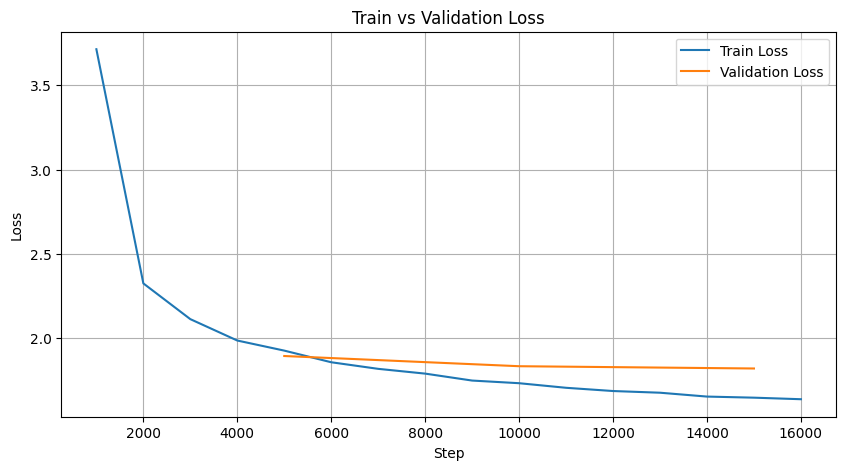

In [43]:
import json
import pandas as pd
import matplotlib.pyplot as plt

state_path = "/content/checkpoint-16260/trainer_state.json"

with open(state_path, "r") as f:
    state = json.load(f)

logs = state["log_history"]

df = pd.DataFrame(logs)

train_df = df[df["loss"].notnull()]
val_df   = df[df["eval_loss"].notnull()]

plt.figure(figsize=(10,5))
plt.plot(train_df["step"], train_df["loss"], label="Train Loss")
plt.plot(val_df["step"], val_df["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

#### Push to HF

In [44]:
from huggingface_hub import notebook_login

notebook_login()

In [45]:
from huggingface_hub import create_repo
create_repo("machine-translation-synthetic-data-v1-data200k", private=True)

RepoUrl('https://huggingface.co/tnguyen20604/machine-translation-synthetic-data-v1-data200k', endpoint='https://huggingface.co', repo_type='model', repo_id='tnguyen20604/machine-translation-synthetic-data-v1-data200k')

In [46]:
from huggingface_hub import upload_folder

upload_folder(
    repo_id="tnguyen20604/machine-translation-synthetic-data-v1-data200k",
    folder_path="checkpoint-16260",
    commit_message="Upload checkpoint"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...kpoint-16260/spiece.model: 100%|##########|  820kB /  820kB            

  ...kpoint-16260/optimizer.pt:   0%|          | 38.2kB / 1.81GB            

  ...t-16260/model.safetensors:   0%|          |  554kB /  904MB            

  ...int-16260/rng_state_0.pth:  12%|#2        | 1.75kB / 14.5kB            

  ...int-16260/rng_state_1.pth:  12%|#2        | 1.75kB / 14.5kB            

  ...heckpoint-16260/scaler.pt:  12%|#2        |   119B /   988B            

  ...kpoint-16260/scheduler.pt:  12%|#2        |   128B / 1.06kB            

  ...t-16260/training_args.bin:  12%|#2        |   670B / 5.56kB            

CommitInfo(commit_url='https://huggingface.co/tnguyen20604/machine-translation-synthetic-data-v1-data200k/commit/2c70b7036fd74772d6d50aa6c6d039d6114750b3', commit_message='Upload checkpoint', commit_description='', oid='2c70b7036fd74772d6d50aa6c6d039d6114750b3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tnguyen20604/machine-translation-synthetic-data-v1-data200k', endpoint='https://huggingface.co', repo_type='model', repo_id='tnguyen20604/machine-translation-synthetic-data-v1-data200k'), pr_revision=None, pr_num=None)

#### Download fine-tuning model

In [47]:
from huggingface_hub import notebook_login

notebook_login()

In [48]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("tnguyen20604/machine-translation-synthetic-data-v1-data200k")

model = AutoModelForSeq2SeqLM.from_pretrained(
    "tnguyen20604/machine-translation-synthetic-data-v1-data200k",
    torch_dtype="float16",
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [49]:
text = "vi_en: Đêm trường trung cổ là nỗi ám ảnh kinh hoàng của lịch sử châu Âu"
inputs = tokenizer(text, return_tensors="pt").to("cuda")

output = model.generate(**inputs, max_length=64)
print(tokenizer.decode(output[0], skip_special_tokens=True))

The Middle East night was the terrible haunt of Europe history


#### Evaluate

##### a)

In [50]:
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score sacrebleu

In [51]:
import evaluate

In [52]:
def tokenize_fn(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        batch["target_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )["input_ids"]

    labels = [
        [(t if t != tokenizer.pad_token_id else -100) for t in label]
        for label in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs

# train_tok = ds_train.map(tokenize_fn, batched=True, remove_columns=ds_train.column_names)
# valid_tok = ds_valid.map(tokenize_fn, batched=True, remove_columns=ds_valid.column_names)
test_tok  = ds_vi2en_test.map(tokenize_fn,  batched=True, remove_columns=ds_vi2en_test.column_names)

Map:   0%|          | 0/25402 [00:00<?, ? examples/s]

In [53]:
metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [54]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./nlp_mt_endterm_vi_en_v6_data200k",
    eval_strategy="steps",
    eval_steps=5000,

    save_strategy="steps",
    save_steps=5000,

    logging_strategy="steps",
    logging_steps=1000,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    num_train_epochs=10,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    label_smoothing_factor=0.1,
    weight_decay=0.01,


    fp16=True,
    report_to="none",
    run_name="vit5_en_vi_ft",
    group_by_length=True,
    gradient_checkpointing=True,
    predict_with_generate=True,

    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True
)

In [55]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_tok,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3)  # STOP nếu BLEU không cải thiện 3 lần liên tiếp
    ]
)

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [56]:
def batch_generate(model, tokenizer, texts, batch_size=32):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to("cuda")

        outputs = model.generate(
            **inputs,
            max_length=64,
            num_beams=1   # nhanh nhất
        )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        preds.extend(decoded)

    return preds

In [57]:
# Chuẩn bị dữ liệu
texts = [item["input_text"] for item in ds_vi2en_test]
refs  = [item["target_text"] for item in ds_vi2en_test]

# Generate
preds = batch_generate(model, tokenizer, texts, batch_size=32)

In [58]:
bleu = evaluate.load("sacrebleu")
chrf = evaluate.load("chrf")
rouge = evaluate.load("rouge")

bleu_res = bleu.compute(predictions=preds, references=refs)
chrf_res = chrf.compute(predictions=preds, references=refs)
rouge_res = rouge.compute(predictions=preds, references=refs)

print("BLEU:", bleu_res)
print("chrF:", chrf_res)
print("ROUGE:", rouge_res)

BLEU: {'score': 66.45956352860706, 'counts': [156901, 114847, 84312, 60409], 'totals': [184635, 159233, 133831, 108616], 'precisions': [84.97901264657297, 72.12512481709193, 62.998856767116735, 55.61703616410105], 'bp': 0.9762764035339556, 'sys_len': 184635, 'ref_len': 189068}
chrF: {'score': 78.56653358982047, 'char_order': 6, 'word_order': 0, 'beta': 2}
ROUGE: {'rouge1': np.float64(0.8429559416678529), 'rouge2': np.float64(0.704353810340492), 'rougeL': np.float64(0.8394493647343156), 'rougeLsum': np.float64(0.8393682323485011)}


In [59]:
test_results = trainer.evaluate(eval_dataset=test_tok)
test_loss = test_results["eval_loss"]
test_ppl = math.exp(test_loss)
print("Test Perplexity:", test_ppl)

Test Perplexity: 6.133248337424947


##### b)

In [ ]:
!pip install -q google-generativeai

In [ ]:
import google.generativeai as genai

genai.configure(api_key="key")
gemini_model = genai.GenerativeModel("gemini-2.5-flash")

In [ ]:
# import google.generativeai as genai
# from google.colab import userdata

# # Get the API key from Colab secrets
# # GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# # Configure the Gemini API
# # genai.configure(api_key=GOOGLE_API_KEY)

# try:
#     print("Available Gemini models:")
#     for m in genai.list_models():
#         if 'generateContent' in m.supported_generation_methods:
#             print(f"- {m.name}")
# except Exception as e:
#     print(f"An error occurred while fetching models: {e}")

In [ ]:
evaluation_prompt = """
You are an expert evaluator for machine translation.

Evaluate the translation on:
- Adequacy (meaning preserved)
- Fluency (naturalness)
- Faithfulness (no hallucination)

Score the translation from 0 to 10.

Return ONLY a JSON object:
{{"score": <number>, "comment": "<short explanation>"}}

[Source]: "{src}"
[Prediction]: "{pred}"
[Reference]: "{ref}"
"""

In [ ]:
import json
import re

def extract_json(text):
    match = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except:
            return {"score": None, "comment": "JSON parse failed", "raw": text}
    return {"score": None, "comment": "No JSON found", "raw": text}

In [ ]:
def llm_evaluate(src, pred, ref):
    prompt = evaluation_prompt.format(src=src, pred=pred, ref=ref)
    response = gemini_model.generate_content(prompt).text
    return extract_json(response)

In [ ]:
samples = ds_vi2en_test.select(range(100))
# samples = list(ds_test_bi.values())

llm_scores = []
llm_comments = []

for item in samples:
    src = item["input_text"]
    ref = item["target_text"]

    pred = batch_generate(model, tokenizer, [src])[0]

    result = llm_evaluate(src, pred, ref)
    llm_scores.append(result["score"])
    llm_comments.append(result.get("comment", ""))

In [ ]:
import numpy as np

clean_scores = [s for s in llm_scores if s is not None]

final_score = np.nanmean(clean_scores)
print("LLM-based Score:", final_score)